- The lightcurve


In [3]:
import stingray
from stingray import EventList
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

We have to read events from the input fits file:

In [4]:
filename  = "lightcurves/ni1200120113_0mpu7_cl.evt"    # opens input fits file
evt       = EventList.read(filename) #, "hea")         # reads the event list. Parameter "hea" refers to "heasarc-supported missions" 

In [5]:
## Examples of EventList attributes (press shift+tab to see admitted parameters and available attributes):

#evt.time 
#evt.gti
#evt.pi
#evt.energy

print(evt.mission)

nicer


The first thing we need to do is to choose the energy bands for lightcurves extraction (we need to inspect the energy spectrum!). Then we will extract events in the chosen bands.

In [6]:
## Choose energy bands. For nicer data we can directly give energy as an input (Stingray makes the conversion), otherwise use PI channel

eband_soft = [0.5, 1.]   
eband_hard = [2., 5.]
eband_tot  = [0.5, 10.]

In [7]:
## Filter events in selected energy bands

evt_soft = evt.filter_energy_range(eband_soft)  
evt_hard = evt.filter_energy_range(eband_hard)
evt_tot  = evt.filter_energy_range(eband_tot)

The time bin sets the Nyquist frequency ($\nu_{Nyq}=\frac{1}{2\Delta t}$) which is the maximum frequency accessible in the power spectrum. Variability on timescales shorter than $\frac{1}{\nu_{Nyq}}$ cannot be directly sampled (this gives rise to aliasing, whereby these high-frequency variations are misinterpreted as lower-frequency variability in the sampled data).

--> Extract a light curve using different time bin sizes to show that larger time bins dilute fast variations in the observed signal.

In [8]:
## Small timebin --> faster sampling --> access to high frequency variability

dt1  = 0.4                       # choose time bin (in seconds)
lc1 = evt_tot.to_lc(dt = dt1)    # extracts lightcurve (attributes: lc.counts or lc.countrate)

In [9]:
## Larger timebin --> slower sampling --> no access to high frequency variability 

dt2  = 1.8                       # choose time bin (in seconds)
lc2 = evt_tot.to_lc(dt = dt2)    # extracts lightcurve (attributes: lc.counts or lc.countrate)

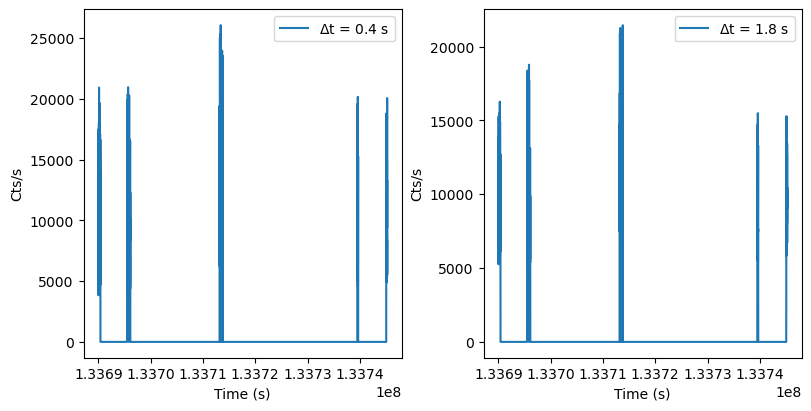

In [10]:
## Plot lightcurves

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)
ax1.plot(lc1.time,lc1.countrate, label=rf"$\Delta$t = {lc1.dt} s")
ax2.plot(lc2.time,lc2.countrate, label=rf"$\Delta$t = {lc2.dt} s")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Cts/s")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Cts/s")
ax1.legend()
ax2.legend()
plt.show()
plt.close("all")

This is a NICER observations, gaps are due to Earth occultation, South Atlantic Anomaly filtering, filtered high particles events, etc. 
To clearly see short term variability we have to zoom in. We can do it by plotting a single GTI

In [11]:
## Print all gtis (to choose the one we want to plot)

print(evt_tot.gti)

[[1.33689926e+08 1.33690374e+08]
 [1.33695466e+08 1.33695792e+08]
 [1.33695794e+08 1.33696071e+08]
 [1.33713163e+08 1.33713274e+08]
 [1.33713279e+08 1.33713297e+08]
 [1.33713302e+08 1.33713527e+08]
 [1.33713531e+08 1.33713688e+08]
 [1.33713700e+08 1.33713711e+08]
 [1.33713723e+08 1.33713780e+08]
 [1.33713797e+08 1.33713812e+08]
 [1.33739512e+08 1.33739679e+08]
 [1.33745054e+08 1.33745239e+08]]


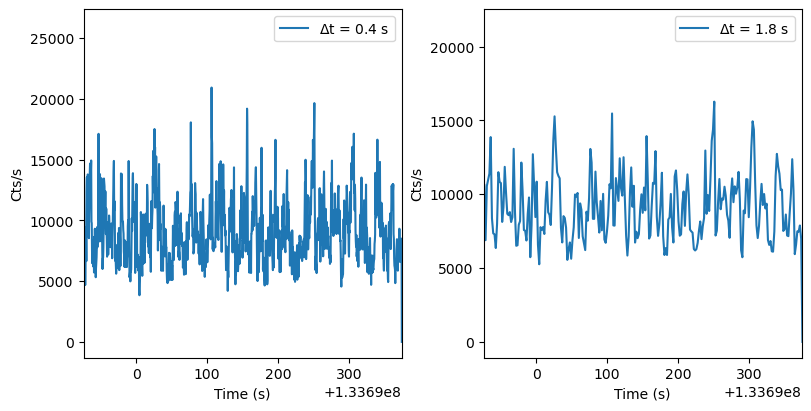

In [12]:
## Plot first GTI lightcurve

x0 = evt_tot.gti[0,0]
x1 = evt_tot.gti[0,1]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)
ax1.plot(lc1.time,lc1.countrate, label=rf"$\Delta$t = {lc1.dt} s")                #r --> prevents python to interpret \D in \Delta before latex does
ax2.plot(lc2.time,lc2.countrate, label=rf"$\Delta$t = {lc2.dt} s")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Cts/s")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Cts/s")
ax1.set_xlim(x0,x1)
ax2.set_xlim(x0,x1)
ax1.legend()
ax2.legend()
plt.show()
plt.close("all")

Fast variability is averaged out using larger time bins.
The appropriate choice of time bin, $dt$, depends on the scientific goal of the analysis. If we aim to study variability features at high frequencies, $dt$ must be sufficiently small. However, our ability to detect intrinsic high-frequency variability is limited by signal-to-noise, which improves with higher count rates and larger intrinsic variability amplitudes.

In practice, the variability power of these sources typically decreases toward high frequencies. As a result, there is a frequency above which the observed signal becomes dominated by Poisson noise, arising from the discrete nature of photon counting. Despite this, it can still be useful to extend the analysis to high frequencies in order to accurately determine the Poisson noise level.

Simply inspecting the light curves is not sufficient to make an informed choice of time binning. To tailor the analysis to our scientific objectives, we must instead examine the power spectrum. As we will see shortly, increasing the time-bin size effectively suppresses the high-frequency portion of the power spectrum.

- The power spectrum (rebinning)

In [13]:
from stingray import AveragedPowerspectrum

To estimate the power spectrum, the light curve is divided into shorter segments. The length $T$ of the segment sets the minimum sampled frequency and the frequency resolution of the power spectrum ($f_{min}=\Delta f=\frac{1}{T}=\frac{1}{N\Delta t}$, where $N$ is the number of time bins in each segments). Periodograms are calculated for each segment and then averaged. This reduces the intrinsic scatter of individual periodograms and yields a more reliable estimate of the underlying variability properties (this applies also to cross spectra). 

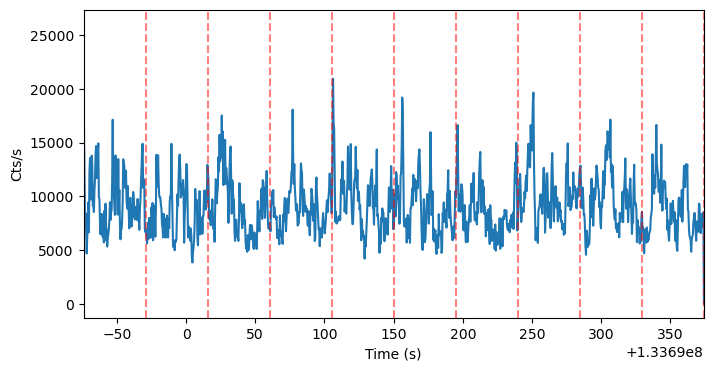

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(lc1.time,lc1.countrate)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Cts/s")

tstart = evt_tot.gti[0, 0]
tstop  = evt_tot.gti[0, 1]
ax.set_xlim(tstart, tstop)

n_segments = 10
segment_edges = np.linspace(tstart, tstop, n_segments + 1)
for edge in segment_edges:
    ax.axvline(edge, color='red', linestyle='--', alpha=0.5)
    

plt.show()
plt.close("all")

--> Show that averaging periodograms reduces the scatter. 

1) To show that a single periodogram is highly scattered around the underlying power spectrum, we give as an input a segment size as large as the length of the largest GTI interval (this selects only one segment):

In [15]:
gti_length = evt_tot.gti[:,1]-evt_tot.gti[:,0]  # compute the length of GTI segments
Tseg       = np.max(gti_length)                 # select the longest
dt         = 0.004                              # choose time bin
norm       = 'leahy'                            # choose power spectrum normalization

psd_unbin  = AveragedPowerspectrum.from_events(evt_tot, segment_size=Tseg, dt = dt, norm = norm, gti=evt_tot.gti)   

In [16]:
print("Segment size", Tseg)                 # print size of selected segment
print("Number of segments:", psd_unbin.m)   # print number of averaged periodograms

Segment size 448.0
Number of segments: 1


In [17]:
frac_err = psd_unbin.power_err/psd_unbin.power          # compute the fractional error
print("Average fractional error: ", np.mean(frac_err))  # print the average fractional error

Average fractional error:  1.0


This shows that the error on the power is of the order of the power. 

2. Now we average over more segments (simply by reducing the segment size):

In [18]:
Tseg     = 50   # choose a small segment size 
psd      = AveragedPowerspectrum.from_events(evt_tot, segment_size=Tseg, dt = dt, norm = norm, gti=evt_tot.gti)  

In [19]:
frac_err = psd.power_err/psd.power                     # compute the fractional error
print("Number of segments:", psd.m)                    # print number of averaged segments 
print("Average fractional error: ", np.mean(frac_err)) # print average fractional error 

Number of segments: 35
Average fractional error:  0.1690308509457033


Alternatively, or in addition, we can reduce the scatter by rebinning a periodogram into larger frequency bins (in doing so we are still averaging periodograms!). 

--> Consider the unbinned periodogram, rebin it logarithmically ($\nu_{i+1}=\nu_i*(1+f)\rightarrow \log(\nu_{i+1})=\log{\nu_i}+\Delta$), and show that the error decreases as the number of averaged frequencies per bin increases.

In [20]:
psd_reb = psd_unbin.rebin_log(f=0.05)          # logarithmic rebinning (choose rebinning factor f)

In [21]:
print("Number of averaged frequencies in each bin: ")
print(psd_reb.m)

Number of averaged frequencies in each bin: 
[   1    1    1    1    2    1    1    2    1    2    1    2    2    2
    2    2    2    2    3    2    3    3    2    4    3    3    4    3
    4    4    5    4    5    5    5    6    6    6    6    7    7    7
    8    8    9    9    9   10   10   11   12   12   12   14   14   14
   16   16   17   18   18   20   20   22   23   24   25   26   28   29
   30   32   33   36   37   38   41   43   45   47   50   52   54   58
   60   63   67   69   74   77   80   85   89   94   98  103  108  114
  119  125  132  138  145  152  160  167  177  185  194  204  214  225
  236  248  261  273  287  301  317  332  349  367  384  404  424  446
  467  491  516  541  568  597  627  657  691  726  761  800  840  881
  926  972 1021 1072 1125 1181 1241 1303 1367 1437 1508 1583 1662 1746
 1833 1925 2021 2121 2228 2340 2456 2579 1857]


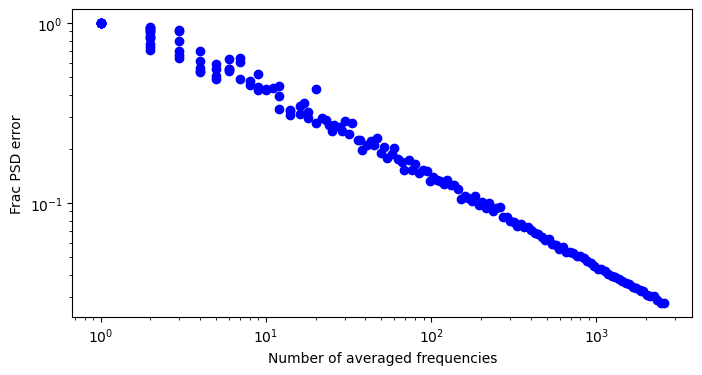

In [22]:
## Compute fractional error and plot it as a function of number of averaged frequencies per bin

frac_err = psd_reb.power_err/psd_reb.power       

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(psd_reb.m, frac_err, color='blue')
ax.set_ylabel("Frac PSD error")
ax.set_xlabel("Number of averaged frequencies")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()
plt.close("all")

We have thus shown that the uncertainty on the power spectrum decreases as the number of averaged periodograms increases and that we can average over broader frequency bins and/or divide the light curve into a larger number of shorter segments. Each approach, however, involves trade-offs between, e.g. frequency resolution, statistical precision, sensitivity to non-stationarity, etc. Consequently, the optimal strategy depends on the specific scientific objectives of the analysis.

For example, if our goal is to study narrow features such as quasi-periodic oscillations (QPOs), we must ensure high frequency resolution. This requires using long data segments and finely spaced frequency bins. In contrast, when focusing on broadband noise, shorter segments and/or larger frequency bins can be adopted. However, shorter segments come at the cost of reduced sensitivity to low-frequency variability, since information at frequencies below the inverse segment length is lost:

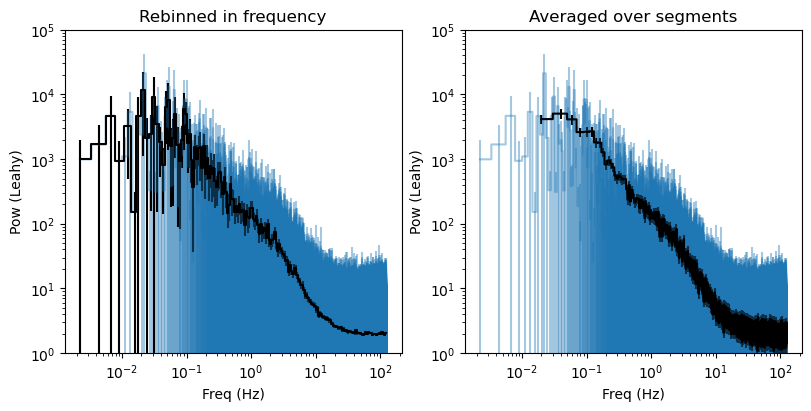

In [23]:
## Plot rebinned power spectra on top of unrebinned ones

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)
ax1.errorbar(psd_unbin.freq,psd_unbin.power,yerr=psd_unbin.power_err,ds='steps-mid', alpha=0.4) 
ax1.errorbar(psd_reb.freq,psd_reb.power,yerr=psd_reb.power_err,ds='steps-mid', color='black')
ax2.errorbar(psd_unbin.freq,psd_unbin.power,yerr=psd_unbin.power_err,ds='steps-mid', alpha=0.4) 
ax2.errorbar(psd.freq,psd.power,yerr=psd.power_err,ds='steps-mid', color='black')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("Freq (Hz)")
ax1.set_ylabel("Pow (Leahy)")
ax1.set_title("Rebinned in frequency")

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Freq (Hz)")
ax2.set_ylabel("Pow (Leahy)")
ax2.set_title("Averaged over segments")

ax1.set_ylim(1, 1e5)
ax2.set_ylim(1,1e5)
plt.show()
plt.close("all")

On the left the power spectrum is rebinned in frequency: depending on the width of the frequency bins, we may loose frequency resolution. Since we adopted a logarithmic rebinning, the highest frequency bins contain more points and have a smaller scatter. Note that each frequency bin contains a different number of averaged points. So each point follows $\chi^2$ distributions with a different number of degrees of freedom. In particular, the distribution tends to a normal distribution as the frequency increases.

On the right the power spectrum is computed by averaging over smaller segments (each bin contains the same number of averaged points): we loose access to the lowest frequencies, and the frequency resolution is worse, as $f_{min}=\Delta f=\frac{1}{N\Delta t}$.

- The power spectrum (Poisson noise)

At high frequencies the power spectrum flattens because it becomes dominated by counting (Poisson) noise (white noise). The maximum accessible frequency is set by the chosen time-bin size ($f_{max}=f_{Nyq}=\frac{1}{2\Delta t}$). To adequately sample the Poisson noise, a sufficiently small time bin must therefore be adopted. Identifying the frequency range over which counting noise dominates is essential, as it defines the highest frequencies for which the analysis remains physically meaningful.

The theoretical Poisson noise level depends on the chosen normalization (see e.g. Vaughan et al. 2003).
In the "Leahy" normalization, the power spectrum is defined such that pure Poisson noise has a constant power of 2. By plotting the rebinned power spectrum, we can verify whether this expected level is reached at high frequencies.

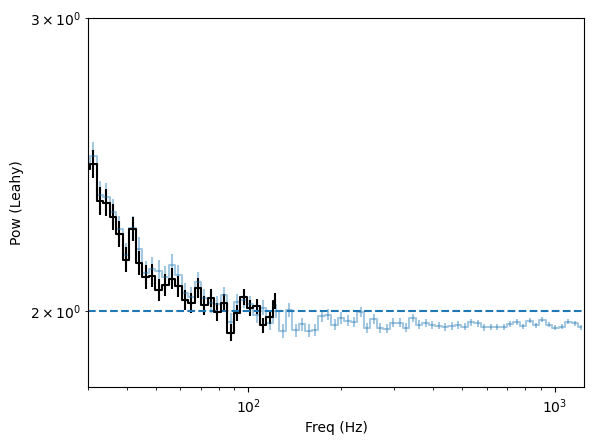

In [24]:
dt           = 0.0004        # choose a small time bin to better sample Poisson noise 
Tseg         = 50  
psd_new      = AveragedPowerspectrum.from_events(evt_tot, segment_size=Tseg, dt = dt, norm = norm, gti=evt_tot.gti)  
psd_reb      = psd_new.rebin_log(f=0.05)
psd_reb_old  = psd.rebin_log(f=0.05)

fig, ax = plt.subplots()
ax.errorbar(psd_reb.freq,psd_reb.power,yerr=psd_reb.power_err,ds='steps-mid', alpha=0.4)
ax.errorbar(psd_reb_old.freq,psd_reb_old.power,yerr=psd_reb_old.power_err,ds='steps-mid',color='black')
ax.axhline(2, linestyle="--")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Freq (Hz)")
ax.set_ylabel("Pow (Leahy)")
ax.set_xlim(30, 1/(2*dt))
ax.set_ylim(1.8,3)
plt.show()
plt.close("all")

Why is the high-frequency, flat portion of the PSD lower than the predicted value of 2 for Leahy normalization? Probably dead-time (see Webbe & Young 2024). Dead-time refers to the fraction of time during which the detector is unable to register the arrival of incoming photons. Counting noise arises from statistically independent events and therefore follows Poisson statistics, producing a white noise power spectrum. In the presence of dead-time, events are not independent anymore, because the detection of one event depends on whether another event has been registered within a time interval shorter than the detector dead-time, which introduces anti-correlations between events. Thus, in the presence of dead-time, events are no longer Poisson distributed. For a Poisson process $\mathrm{Var}(N) = \langle N \rangle$. Dead-time reduces the randomness of the detection process, suppressing the observed fluctuations, so that $\mathrm{Var}(N) < \langle N \rangle$. Consequently, for a light curve affected by dead-time, the white noise level in the power spectrum is lower than it would be in the absence of dead-time (e.g., lower than 2 in Leahy normalization). A key aspect is that for a fixed dead-time, the effects might be negligible if the source is faint (i.e. when the photons arrival rate is low). However, for bright sources (like the one we are analyzing), even a short dead-time can have a significant impact because the probability of closely spaced photon arrival times is high.
In some cases dead-time can be modelled. Alternatively, if we are analyzing frequencies $\ll 1/\tau_{deadtime}$, the dead-time–modified noise remains approximately flat, resembling white noise. In this regime, the white-noise level can be estimated by fitting the high-frequency portion of the power spectrum (while still satisfying $\nu \ll 1/\tau_{deadtime}$) with a constant model.

In [25]:
## Select high frequencies where Poisson noise dominates

mask     = psd_reb.freq >= 200
freq_wn  = psd_reb.freq[mask]
power_wn = psd_reb.power[mask]
err_wn   = psd_reb.power_err[mask]

In [26]:
## Fit high frequencies with a constant model 

from scipy.optimize import curve_fit

def constant(x, c):
    return c

cfit, cov = curve_fit(
    constant,
    freq_wn,
    power_wn,
    sigma=err_wn,
)

const_level = cfit[0]
const_err   = np.sqrt(np.diag(cov)) #takes square root of diagonal elements in covariance array (i.e. variances of fitted parameters)

print("Best-fit white noise power:",const_level)
print("Error on white noise power:",const_err[0])


Best-fit white noise power: 1.962832855832953
Error on white noise power: 0.001330485955300559


However, note that dead-time does not affect only Poisson-noise variability, but it attenuates also intrinsic source variability at all frequencies (most strongly at high frequencies, because it tends to suppress rapid variations). So with the method of fitting the dead time and then subtracting it, we are not correcting for this effect, and the intrinsic source power that we infer is, in fact, only a lower limit. Recovering the intrinsic rms generally requires an explicit dead-time correction. In this case we don't care, because dead-time is really small.

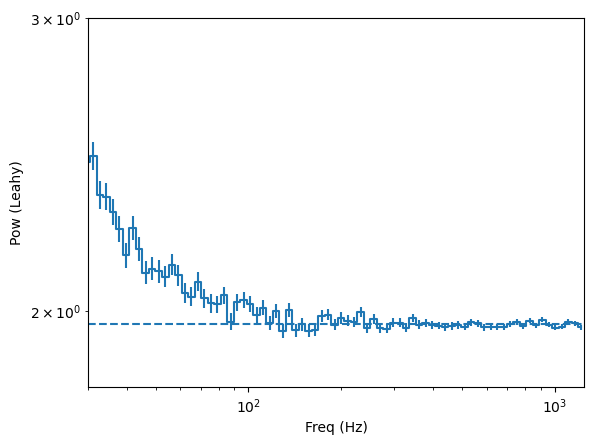

In [27]:
## Plot power spectrum with fitted Poisson noise level

fig, ax = plt.subplots()
ax.errorbar(psd_reb.freq,psd_reb.power,yerr=psd_reb.power_err,ds='steps-mid') 
ax.axhline(const_level, linestyle="--")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Freq (Hz)")
ax.set_ylabel("Pow (Leahy)")
ax.set_xlim(30, 1/(2*dt))
ax.set_ylim(1.8,3)
plt.show()
plt.close("all")

We therefore find that up to frequencies of $\sim 100-200$Hz the intrinsic variability power of the source dominates over the counting-noise contribution. By subtracting the fitted Poisson noise level, we can thus obtain an estimate of the intrinsic power spectrum.

When performing this subtraction, the uncertainty in the Poisson noise level should, in principle, be taken into account. This can be done by adding in quadrature the uncertainties on the measured power spectrum and on the Poisson noise level, $\sigma=\sqrt{\sigma^2_{PDS}+\sigma^2_{Poiss}}$. If the Poisson noise is determined through fitting over a sufficiently wide frequency range, its uncertainty is expected to be much smaller than that of the power spectrum itself, i.e. $\sigma^2_{Poiss}\ll \sigma^2_{PDS}$. Nevertheless, for completeness and methodological rigor, we include the uncertainty associated with the subtracted Poisson noise in the computation of the power spectrum errors, even though its contribution is negligible in practice.

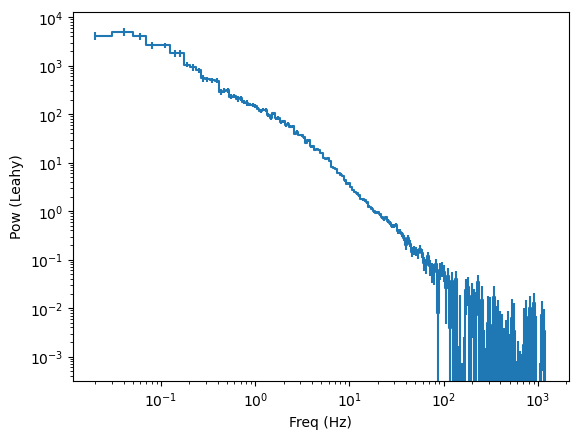

In [28]:
new_psd_err=np.sqrt(psd_reb.power_err**2+const_err[0]**2)     #error on PDS after Poisson noise subtraction

fig, ax = plt.subplots()
ax.errorbar(psd_reb.freq,psd_reb.power-const_level,yerr=new_psd_err,ds='steps-mid') 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Freq (Hz)")
ax.set_ylabel("Pow (Leahy)")
plt.show()
plt.close("all")

(Since we fit the Poisson noise over a large frequency range, if we did not correct the power spectrum error for the Poisson noise uncertainty, the resulting errors would be approximately the same:)

In [29]:
print(np.abs(psd_reb.power_err/new_psd_err))

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.99999999 0.99999999 0.99999999 0.99999999
 0.99999998 0.99999998 0.99999999 0.99999998 0.99999998 0.99999996
 0.99999997 0.99999995 0.99999996 0.99999993 0.99999994 0.99999988
 0.99999988 0.99999984 0.99999982 0.99999979 0.99999964 0.99999968
 0.99999945 0.9999994  0.99999909 0.9999992  0.99999912 0.99999866
 0.99999795 0.99999776 0.9999976  0.99999695 0.99999491 0.99999445
 0.99999396 0.99999067 0.99998966 0.99998745 0.99998222 0.99997737
 0.99997687 0.99997018 0.99996178 0.99995616 0.99995054 0.99994194
 0.99992974 0.99992218 0.99991585 0.99990689 0.99987907 0.99986292
 0.99984494 0.99983144 0.99982185 0.99980449 0.99977866 0.99975482
 0.99975467 0.99972153 0.99968127 0.99965763 0.99963056 0.99962284
 0.99956278 0.99953578 0.99

- The power spectrum (fractional rms)

In [30]:
f_min        = 0.01
f_max        = 50.
rms, err_rms = psd.compute_rms(f_min, f_max, poisson_noise_level=const_level) # does not matter if input power spectrum and poisson noise level are computed in a different normalization
print(rms, err_rms)

0.3236136766748716365 0.005099864384989766047


The high fractional rms indicates that the source is in the hard spectral state.

- Energy-dependent power spectra

We can use the events extracted in the two energy bands of interest to study energy-dependent variability. Given the energy spectrum of this observation, we chose to consider energy bands dominated by the disc and comptonization components to study the causal relation between these two components.
The first thing we might want to know is which component is more variable and over which timescales. A first indication can be obtained by looking at the power spectra in the two bands.

In [98]:
norm     = 'leahy'     # for the moment let's keep this normalization

Tseg     = 100         # we choose a longer segment size, in order to have access to the lowest frequencies, and to have better frequency resolution
dt       = 0.0004      # we keep a high dt to have access to the highest frequency variability and to be able to properly fit the Poisson noise power
psd_soft = AveragedPowerspectrum.from_events(evt_soft, segment_size=Tseg, dt = dt, norm = norm, gti=evt_soft.gti)
psd_hard = AveragedPowerspectrum.from_events(evt_hard, segment_size=Tseg, dt = dt, norm = norm, gti=evt_hard.gti)   

psd_reb_soft = psd_soft.rebin_log(f=0.1)
psd_reb_hard = psd_hard.rebin_log(f=0.1)

#print(psd_soft.m)      #prints the number of segments
#print(psd_reb_soft.m)  #prints the number of averaged power spectra (=number of segments x number of frequencies in a bin)

Now we plot the power spectra. However, the normalization we chose is such that the Poisson noise level aligns in the two bands:

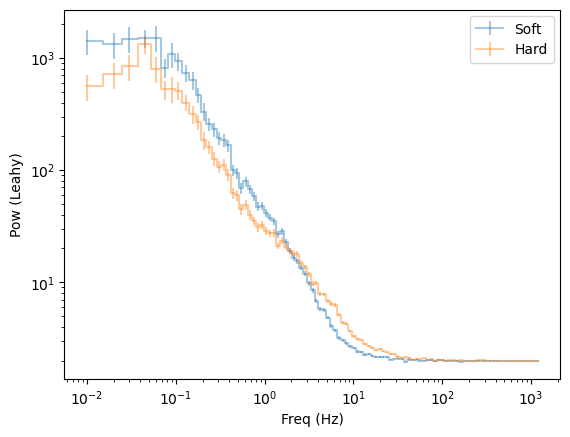

In [100]:
fig, ax = plt.subplots()
ax.errorbar(psd_reb_soft.freq,psd_reb_soft.power,yerr=psd_reb_soft.power_err,ds='steps-mid', alpha=0.4, label=f"Soft")
ax.errorbar(psd_reb_hard.freq,psd_reb_hard.power,yerr=psd_reb_hard.power_err,ds='steps-mid', alpha=0.4, label=f"Hard") 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Freq (Hz)")
ax.set_ylabel("Pow (Leahy)")
ax.legend()
plt.show()
plt.close("all")

In Leahy normalization the power is in units of $counts\ s^{-1}\ Hz^{-1}$, so a brighter band will show more power. To compare powers (independently of the count rate) we need to renormalize for the average count rate. To do so we use the fractional normalization: 

In [101]:
norm     = 'frac'
psd_soft = AveragedPowerspectrum.from_events(evt_soft, segment_size=Tseg, dt = dt, norm = norm, gti=evt_soft.gti)
psd_hard = AveragedPowerspectrum.from_events(evt_hard, segment_size=Tseg, dt = dt, norm = norm, gti=evt_hard.gti)   

psd_reb_soft = psd_soft.rebin_log(f=0.1)
psd_reb_hard = psd_hard.rebin_log(f=0.1)


Now we will determine the Poisson noise level (by fitting it at high frequencies), and subtract it from the average power spectrum

In [102]:
## Fit Poisson noise

mask     = psd_reb_soft.freq >= 200
freq_wn  = psd_reb_soft.freq[mask]
power_wn = psd_reb_soft.power[mask]
err_wn   = psd_reb_soft.power_err[mask]

cfit, cov = curve_fit(
    constant,
    freq_wn,
    power_wn,
    sigma=err_wn,
)

const_level_soft = cfit[0]
const_err_soft   = np.sqrt(np.diag(cov)) #takes square root of diagonal elements in covariance array (i.e. variances of fitted parameters)

mask     = psd_reb_hard.freq >= 200
freq_wn  = psd_reb_hard.freq[mask]
power_wn = psd_reb_hard.power[mask]
err_wn   = psd_reb_hard.power_err[mask]

cfit, cov = curve_fit(
    constant,
    freq_wn,
    power_wn,
    sigma=err_wn,
)

const_level_hard = cfit[0]
const_err_hard   = np.sqrt(np.diag(cov)) #takes square root of diagonal elements in covariance array (i.e. variances of fitted parameters)

print("Best-fit white noise power [soft, hard]:",const_level_soft, const_level_hard)
print("Error on white noise power [soft, hard]:",const_err_soft[0], const_err_hard[0])



Best-fit white noise power [soft, hard]: 0.00047914628683028723 0.001328790588391797
Error on white noise power [soft, hard]: 4.111879036509507e-07 1.000639313186616e-06


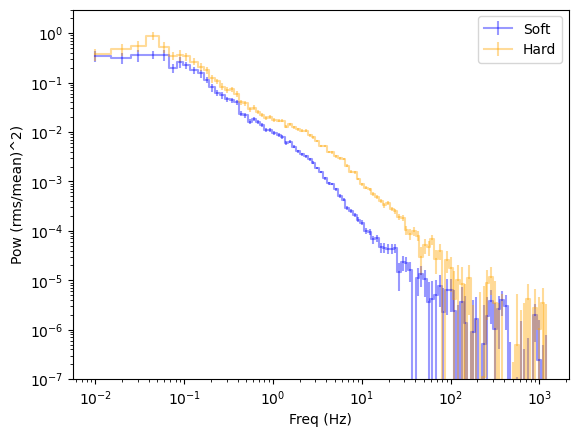

In [103]:
# Plot Poisson noise-subtracted power spectrum in fractional rms units 

sigma_soft = np.sqrt(psd_reb_soft.power_err**2+const_err_soft[0]**2)
sigma_hard = np.sqrt(psd_reb_hard.power_err**2+const_err_hard[0]**2)


fig, ax = plt.subplots()
ax.errorbar(psd_reb_soft.freq,psd_reb_soft.power-const_level_soft,yerr=psd_reb_soft.power_err,ds='steps-mid', color='blue', alpha=0.4, label=f"Soft")
ax.errorbar(psd_reb_hard.freq,psd_reb_hard.power-const_level_hard,yerr=psd_reb_hard.power_err,ds='steps-mid', color='orange', alpha=0.4, label=f"Hard") 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Freq (Hz)")
ax.set_ylabel("Pow (rms/mean)^2)")
ax.set_ylim(1e-7,3)
ax.legend()
plt.show()
plt.close("all")

The hard band is therefore more variable than the soft band at all frequencies. The observation is taken during the bright hard state, and the soft emission is dominated by the accretion disc. We can compute the fractional rms within a selected frequency range of interest.

In [104]:
f_min        = 0.01
f_max        = 50.
rms_soft, err_rms_soft = psd_reb_soft.compute_rms(f_min, f_max, poisson_noise_level=const_level_soft)
rms_hard, err_rms_hard = psd_reb_hard.compute_rms(f_min, f_max, poisson_noise_level=const_level_hard)
print("Soft band fractional rms (0.01-50 Hz): ",rms_soft, err_rms_soft)
print("Hard band fractional rms (0.01-50 Hz): ",rms_hard, err_rms_hard)

Soft band fractional rms (0.01-50 Hz):  0.2807894080637746505 0.0051696287405866839505
Hard band fractional rms (0.01-50 Hz):  0.39574597137132794635 0.0063463314367424061815


Although the soft band is less variable than the hard band, it still exhibits a relatively high fractional rms. 

It is important to note that, although the disc dominates the soft band and the Comptonization component dominates the hard band, the measured fractional rms in each energy band includes anyway contributions from both spectral components. Consequently, these fractional rms values do not represent the intrinsic rms of the disc and Comptonization components, respectively. At this stage, we can therefore only conclude that the disc-dominated energy band is systematically less variable than the power-law–dominated band across all frequencies.

- Cross spectrum

In [37]:
from stingray import AveragedCrossspectrum

Same as for the power spectrum, the unbinned cross spectrum will be very noisy. In the case of the cross spectrum, averaging (over segments and/or frequencies) cancels non-linearly correlated variability, including Poisson noise

In [38]:
Tseg  = 100                  # choose segment size
dt    = 0.0004               # choose time bin
cs    = AveragedCrossspectrum.from_events(evt_hard, evt_soft, segment_size= Tseg, dt = dt, norm = norm)

In [81]:
cs_reb = cs.rebin_log(0.1)

The cross spectrum is a complex quantity. To retreive the real and imaginary parts we can use attributes ".power.real" and "power.imag" in Stingray. The attribute "cs.power" is the squared modulus of the cross spectrum, and represents the correlated power between the two light curves at each frequency. 

--> Explore different ways of representing the cross spectrum

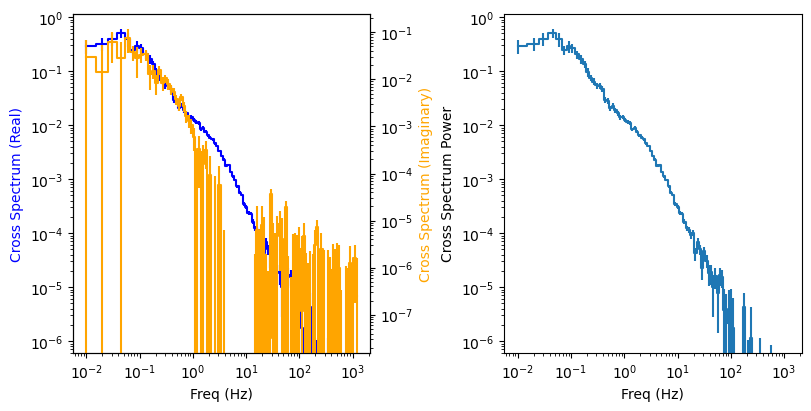

In [82]:
## Plot real and imaginary parts, and the squared modulus of the average cross spectrum

fig, (ax1, ax3) = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)
ax1.errorbar(cs_reb.freq,cs_reb.power.real,yerr=cs_reb.power_err.real,ds='steps-mid', color="blue")
ax2 = ax1.twinx()
ax2.errorbar(cs_reb.freq,cs_reb.power.imag,yerr=cs_reb.power_err.imag,ds='steps-mid', color="orange")
ax3.errorbar(cs_reb.freq,cs_reb.power,yerr=cs_reb.power_err,ds='steps-mid')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')

ax1.set_xlabel("Freq (Hz)")
ax3.set_xlabel("Freq (Hz)")
ax1.set_ylabel("Cross Spectrum (Real)", color="blue")
ax2.set_ylabel("Cross Spectrum (Imaginary)", color="orange")
ax3.set_ylabel("Cross Spectrum Power")
plt.show()
plt.close("all")

By averaging the cross spectrum over multiple segments/frequencies, uncorrelated variations, such as Poisson noise, tend to cancel out (the average cross spectrum of uncorrelated events has zero expectation value). As a result, the averaged cross spectrum primarily reflects only the coherent signal shared by the two light curves. NOTE: since we average over a finite number of cross spectra, Poisson noise is never totally cancelled.

The real and imaginary components of the cross spectrum can be represented as vectors in the complex plane. Coherent variations produce cross spectrum vectors that tend to point in similar directions, i.e., they are approximately in phase. The orientation of each vector corresponds to the phase lag between the signals at a given frequency, while the vector length reflects the amplitude of the correlated variability (see also Nowak et al. 1999). Poisson noise contributes with a random phase.

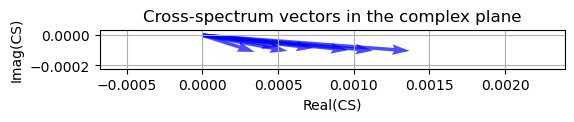

In [83]:
fmin, fmax = 5, 10       # Define frequency limits and axes limits for soft lag

#fmin, fmax = 0.1, 0.5  # Define frequency limits and axes limits for hard lag

#fmin, fmax = 100, 1000  # Define frequency limits and axes limits for Poisson noise


# Mask the frequency range
mask = (cs_reb.freq >= fmin) & (cs_reb.freq <= fmax)

# Select only the masked points
x = cs_reb.power.real[mask]
y = cs_reb.power.imag[mask]


fig, ax = plt.subplots(figsize=(6,6))

ax.quiver(
    [0]*len(x), [0]*len(y),  # origin for each vector
    x, y,                    # vector components
    angles='xy', scale_units='xy', scale=1,
    color='blue', alpha=0.7
)


xpad = 1  
ypad = 3
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

dx = xmax - xmin
dy = ymax - ymin

ax.set_xlim(xmin - xpad * dx, xmax + xpad * dx)
ax.set_ylim(ymin - ypad * dy, ymax + ypad * dy)

ax.set_xlabel("Real(CS)")
ax.set_ylabel("Imag(CS)")
ax.set_title("Cross-spectrum vectors in the complex plane")
ax.grid(True)
ax.set_aspect('equal') 
plt.show()

You can change the frequency range to see how the phase lag changes sign depending on the signs of the real and imaginary parts of the cross spectrum, or you can select a Poisson noise-dominated interval, and see how vectors are randomly distributed in the complex plane, as phases associated with Poisson noise tend to be homogeneously distributed in the interval $[-\pi, \pi]$.

--> You can now get back to the step where you compute the average cross-spectrum and choose a longer segment size (e.g. 500s, because of the gaps and the short duration of GTIs, this choice will reduce the effective number of averaged segments) or do not perform the frequency rebinning. This will increase the contribution from uncorrelated noise resulting in a more scattered vector-plot in a given frequency range.

- Phase and time lags

In [84]:
phase, phase_err = cs_reb.phase_lag()
lag,   lag_err   = cs_reb.time_lag()

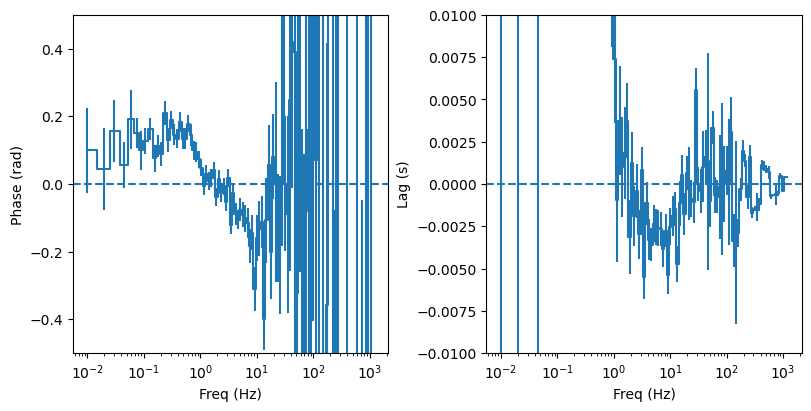

In [86]:
## Plot phase and time lags as a function of frequency

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)
ax1.errorbar(cs_reb.freq,phase,yerr=phase_err,ds='steps-mid')
ax2.errorbar(cs_reb.freq,lag,yerr=lag_err,ds='steps-mid')

ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.axhline(0, linestyle="--")
ax2.axhline(0, linestyle="--")

ax1.set_xlabel("Freq (Hz)")
ax1.set_ylabel("Phase (rad)")

ax2.set_xlabel("Freq (Hz)")
ax2.set_ylabel("Lag (s)")

ax1.set_ylim(-0.5,0.5)
ax2.set_ylim(-0.01,0.01)
#ax2.set_yscale('log')

plt.show()
plt.close("all")

--> Determine maximum time/phase lags from phase wrapping and overplot the curves that describe these limits:

We can see that at high frequencies the lag begins to phase wrap. This happens because, when the measured phase reaches the limits of the interval $\phi=[-\pi,\pi]$ over which the phase lag is mathematically defined, it is forced to wrap back into this interval (by adding or subtracting $2\pi$). These limits correspond to the limits $\tau=[-\frac{1}{2\nu},\frac{1}{2\nu}]$ on the time lag. 

In [87]:
## Compute phase wrapping limits

up_phase  = np.pi * np.ones(len(cs_reb.freq))
low_phase = -np.pi * np.ones(len(cs_reb.freq))

up_lag    = 1./(2*cs_reb.freq)
low_lag   = -1./(2*cs_reb.freq)

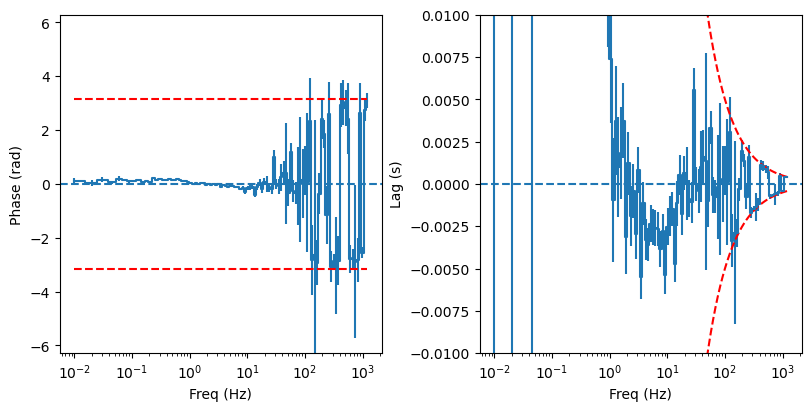

In [88]:
## Plot phase wrapping curves

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)
ax1.errorbar(cs_reb.freq,phase,yerr=phase_err,ds='steps-mid')
ax2.errorbar(cs_reb.freq,lag,yerr=lag_err,ds='steps-mid')

ax1.plot(cs_reb.freq,up_phase, linestyle='--', color='r')
ax1.plot(cs_reb.freq,low_phase, linestyle='--', color='r')

ax2.plot(cs_reb.freq,up_lag, linestyle='--', color='r')
ax2.plot(cs_reb.freq,low_lag, linestyle='--', color='r')

ax1.set_xscale('log')
ax2.set_xscale('log')

ax1.axhline(0, linestyle="--")
ax2.axhline(0, linestyle="--")

ax1.set_xlabel("Freq (Hz)")
ax1.set_ylabel("Phase (rad)")

ax2.set_xlabel("Freq (Hz)")
ax2.set_ylabel("Lag (s)")

ax1.set_ylim(-2*np.pi,2*np.pi)
ax2.set_ylim(-0.01,0.01)

plt.show()
plt.close("all")

This shows that the lags are effectively confined between these two limits. For example, if the intrinsic time lag is constant at all frequencies, the phase lag increases with frequency, until reaching $\pi$, at which point it wraps back into that interval. In the data we are analyzing, Poisson noise random phases dominate the phase-wrapping region. Being random, they produce frequent phase wraps, thus tending to populate the entire interval defined by the two red curves. 

--> Estimate intrinsic amplitude of soft lag

The measured lag amplitude is affected by dilution, which occurs because both energy bands contain contributions from the direct continuum as well as from the component producing the soft lag. If we can assume that one of the two bands contains only continuum photons, and we can estimate the continuum fraction in the other band, then the intrinsic lag amplitude can be estimated using the formula reported in Uttley et al. (2014).

An alternative approach is to infer the intrinsic lag amplitude from the zero-crossing frequency $\nu_{0}$. Assuming a roughly constant time lag at high frequencies, the measured lag will eventually reach the phase-wrapping limit, cross the zero-lag axis, and change sign. Importantly, the first zero-crossing frequency is largely unaffected by dilution, because dilution scales the measured lag amplitude but does not change the frequency at which the lag reaches the phase-wrapping limit. In other words, dilution reduces the observed lag, but the point where the lag reaches zero is determined primarily by the intrinsic lag itself.
For simple cases, the intrinsic lag amplitude can be approximated as $\tau_{intr}\sim \frac{1}{2\nu_{0}}$. 

To apply this method in practice, one should fit a physically motivated model to the lag-frequency spectrum to determine the zero-crossing frequency accurately. Here, for conceptual demonstration, the method is illustrated using a simple interpolation of the data.

In [89]:
cs_rebreb              = cs.rebin_log(0.15)     # we first rebin a bit more in order to reduce scattering in the data
lagreb,   lagreb_err   = cs_rebreb.time_lag()


## Choose a range of frequencies where to search for zero-crossing
fmin = 4     # lower bound in Hz                  
fmax = 100.0 # upper bound in Hz


mask = (cs_rebreb.freq >= fmin) & (cs_rebreb.freq <= fmax)     # Select lag and frequencies in the defined range
freq_sel = cs_rebreb.freq[mask]
lag_sel = lagreb[mask]

In [90]:
## Interpolate the lag frequency spectrum to obtain a smoother curve for more accurate identification of zero-crossing
## TO BE SUBSTITUTED WITH PHYSICAL MODEL FITTING

from scipy.interpolate import CubicSpline                       

spline    = CubicSpline(freq_sel, lag_sel)                      # cubic spline interpolation
freq_fine = np.linspace(fmin, fmax, 5000)                       # define a fine frequency grid for interpolated lag
lag_fine  = spline(freq_fine)                                   # computes interpolated lag on the frequency grid

sign_changes    = np.where(np.diff(np.sign(lag_fine)))[0]       # detects where the lag changes sign
first_cross_idx = sign_changes[0]                               # selects the first crossing

f1, f2          = freq_fine[first_cross_idx:first_cross_idx+2]  # linearly interpolates between the two frequencies of the first crossing
l1, l2          = lag_fine[first_cross_idx:first_cross_idx+2]
zero_cross_freq = f1 - l1 * (f2 - f1) / (l2 - l1)               

First zero-crossing frequency: 16.976952013356563 Hz


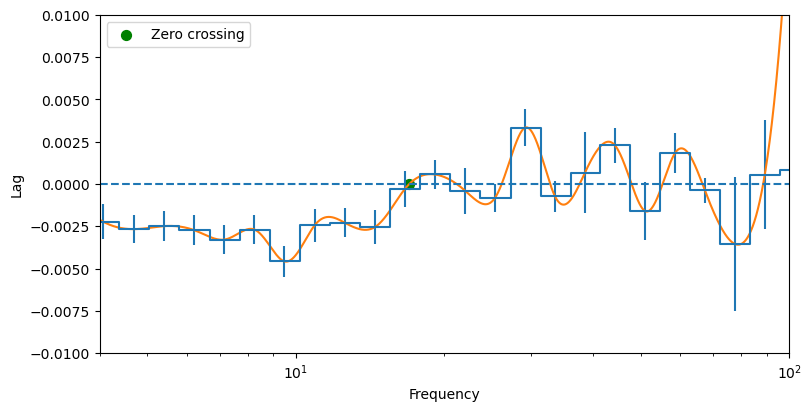

In [91]:
## Plot lag-frequency spectrum, interpolation curve, and zero-crossing frequency

print("First zero-crossing frequency:", zero_cross_freq, "Hz")

fig, ax1 = plt.subplots(ncols=1, figsize=(8, 4), constrained_layout=True)
ax1.errorbar(cs_rebreb.freq,lagreb,yerr=lagreb_err,ds='steps-mid')
ax1.plot(freq_fine, lag_fine, '-')
ax1.scatter([zero_cross_freq], [0], color='green', s=50, label='Zero crossing')

ax1.axhline(0, linestyle="--")
ax1.set_xscale('log')


ax1.set_xlim(fmin,fmax)
ax1.set_ylim(-0.01,0.01)
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Lag')
ax1.legend()
plt.show()
plt.close("all")

Fitting a physically motivated model to the lag-frequency spectrum is preferable to simple interpolation: a model accounts for the underlying physics of the system and provides a more reliable and meaningful estimate of the zero-crossing frequency, and consequently, of the intrinsic lag amplitude. 

In [92]:
## Convert zero-crossing frequency to lag amplitude

fzero_min = zero_cross_freq
tau_intr_max = 1/(2.*fzero_min)

print(f"Estimated intrinsic lag amplitude: {tau_intr_max} s")


Estimated intrinsic lag amplitude: 0.029451694250335784 s


- Coherence (raw)

In [93]:
coh, coh_err = cs_reb.coherence()  # This computes the "raw" coherence

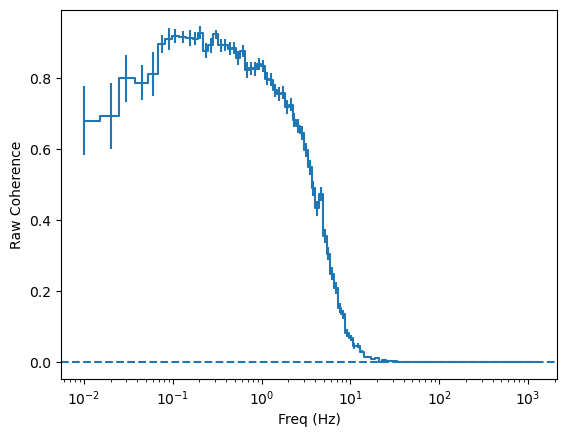

In [94]:
## Plot coherence as a function of frequency

fig, ax = plt.subplots()
ax.errorbar(cs_reb.freq,coh,yerr=coh_err,ds='steps-mid')
ax.set_xscale('log')
ax.axhline(0, linestyle="--")
ax.set_xlabel("Freq (Hz)")
ax.set_ylabel("Raw Coherence")
plt.show()
plt.close("all")

This is the "raw" coherence, where the power spectra in the denominator of the coherence formula have not been corrected for the Poisson noise level. This is used in the standard formula used to calculate the error on the phase lag $\sigma_{\phi}=\sqrt{\frac{1-\gamma^2}{2\gamma^2 WM}}$ (where $WM$ is the number of averaged frequency times the number of averaged segments). In a vector representation of the cross-spectrum, the raw coherence tells us how scattered the averaged cross-spectra are in each bin. 

As expected, the raw coherence drops at high frequencies because the intrinsic power decreases and residual Poisson noise becomes increasingly more important. Poisson noise introduces random phases that increase the scatter of the cross-spectrum vectors in the complex plane, which reduces the measured coherence.

Note that the coherence is defined as $\frac{|\overline{CS}|^2-n^2}{\overline{P}_{soft}\overline{P}_{hard}}$. Even random vectors with zero correlation give $|\overline{CS}|^2\ne 0$. To correct for this bias, we subtract a "bias" term $n^2=(\overline{P}_{soft}-P_{soft,Poiss})\overline{P}_{hard}+(\overline{P}_{hard}-P_{hard,Poiss})\overline{P}_{soft}+P_{soft,Poiss}P_{hard,Poiss}$ , which represents the expected contribution of uncorrelated Poisson noise to the modulus of the cross-spectrum. Vaughan & Nowak (1997) show that this noise contribution can be modeled as a complex random variable whose real and imaginary parts have zero mean and variance $n^2/2$. So by subtracting $n^2$ from $|\overline{CS}|^2$ removes the systematic positive offset caused by noise, ensuring that the average modulus of the cross-spectrum is correctly centered. But this correction does not reduce the scatter of the cross-spectrum vectors themselves: at high frequencies, the increased scatter due to noise still leads to a drop in coherence.

--> We can show that the bias term decreases as the number of averaged cross spectra increases

In [106]:
## Compute bias term

psd_soft_corr = psd_reb_soft.power-const_level_soft
psd_hard_corr = psd_reb_hard.power-const_level_hard

n2 = psd_soft_corr*psd_reb_hard.power + psd_hard_corr*psd_reb_soft.power + const_level_soft*const_level_hard

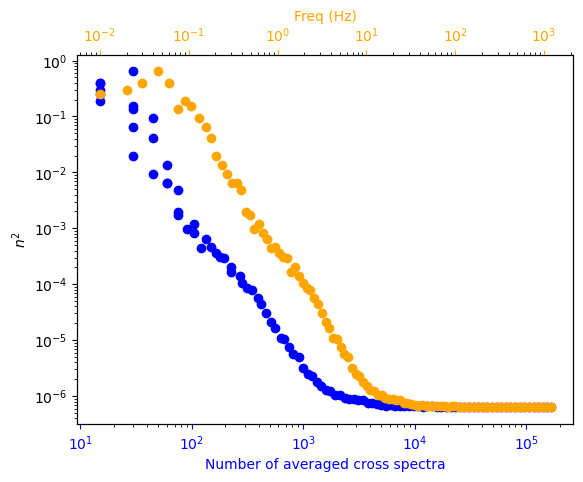

In [108]:
## Plot bias terms vs frequency/number of averaged cross spectra

fig, ax1 = plt.subplots()

ax1.scatter(cs_reb.m, n2, color='blue')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(f"Number of averaged cross spectra", color = 'blue')
ax1.set_ylabel(rf"$n^2$")
ax1.tick_params(axis='x', colors='blue')

ax2 = ax1.twiny()
ax2.scatter(cs_reb.freq, n2, color='orange', label='freq')
ax2.set_xscale('log')
ax2.set_xlabel('Freq (Hz)', color = 'orange')
ax2.tick_params(axis='x', colors='orange')


plt.show()
plt.close("all")

Subtraction of bias term can yield negative coherence in frequency range where Poisson noise contribution is strong. This is due to the fact that, because of finite statistics, $|\overline{CS}|^2$ fluctuates around its expected value, so it can happen that  $|\overline{CS}|^2 < n^2$. In this case we can either set the coherence equal 0, or rebin more (which decreases the scatter of $|\overline{CS}|^2$). When this happens we cannot calculate a meaningful error for the lag using the formula $\sigma_{\phi}=\sqrt{\frac{1-\gamma^2}{2\gamma^2 WM}}$, so we can discard the corresponding lag measurement.

- Coherence (intrinsic) 

The raw coherence of noisy data will always be less than unity. The intrinsic coherence is estimated by correcting the power spectra in the denominator of the coherence function for the Poisson-noise. For the errors on the intrinsic coherence, see Nowak & Vaughan 1997. However, note that an estimate of the intrinsic coherence can be reliably obtained only if the variability power and the raw coherence are high.

In [109]:
coh_int  = coh*( psd_reb_soft.power * psd_reb_hard.power)/( psd_soft_corr * psd_hard_corr)

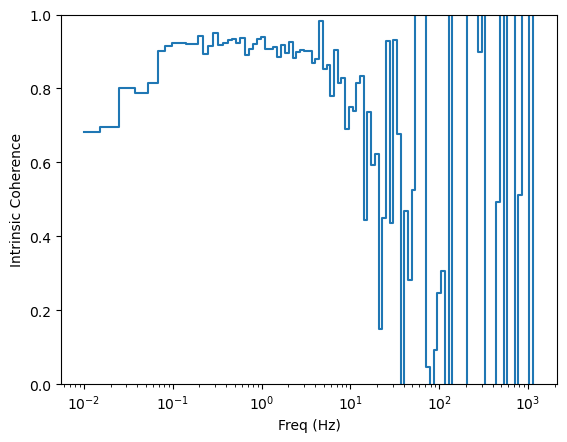

In [110]:
## Plot intrinsic coherence

fig, ax = plt.subplots()
ax.errorbar(cs_reb.freq,coh_int,yerr=coh_err*0,ds='steps-mid')
ax.set_xscale('log')
ax.set_xlabel("Freq (Hz)")
ax.set_ylabel("Intrinsic Coherence")
ax.set_ylim(0,1)
plt.show()
plt.close("all")

- Lag-energy spectrum

In [111]:
from stingray import LagSpectrum

In [112]:
## Choose reference band and channels

ref_band       = [0.5,10]
chan_band      = np.geomspace(0.5, 10, 50)

In [113]:
highfreq       = [3, 10]     # choose frequency range for extraction of lag energy spectrum
lagspec_high   = LagSpectrum(evt, freq_interval=highfreq, segment_size=Tseg, bin_time=dt, energy_spec=chan_band, ref_band=ref_band)

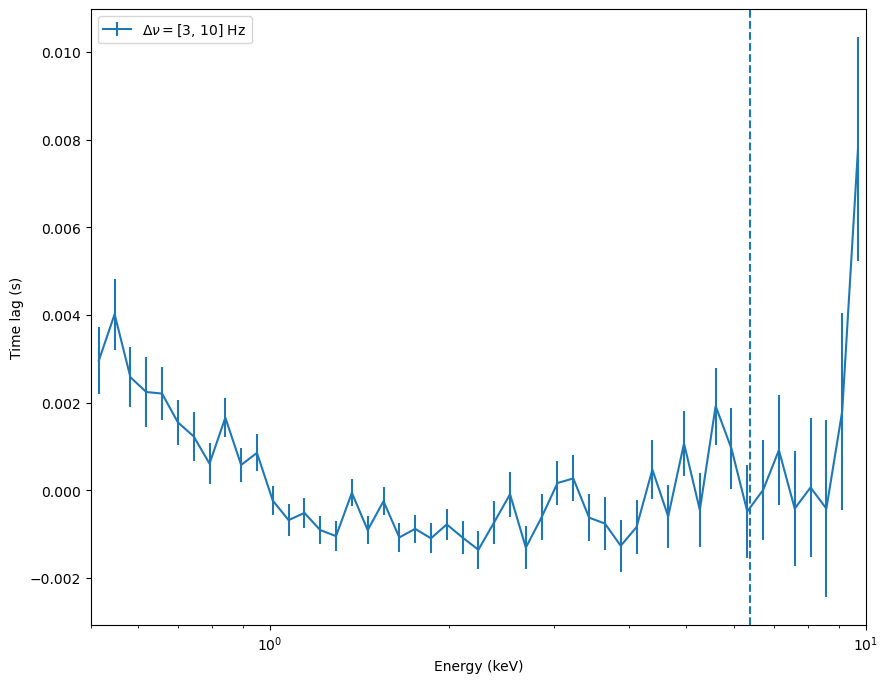

In [114]:
## Plot lag-energy spectrum

fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.errorbar(lagspec_high.energy, lagspec_high.spectrum, yerr=lagspec_high.spectrum_error, label=rf"$\Delta \nu=${highfreq} Hz")

ax.set_xscale('log')
ax.set_xlim(0.5, 10.)

ax.axvline(6.4, linestyle="--")

ax.set_ylabel("Time lag (s)")
ax.set_xlabel("Energy (keV)")
ax.legend()
plt.show()
plt.close("all")

In [115]:
lowfreq      = [0.2, 1]      # choose frequency range for extraction of lag energy spectrum
lagspec_low  = LagSpectrum(evt, freq_interval=lowfreq, segment_size=Tseg, bin_time=dt, energy_spec=chan_band, ref_band=ref_band)

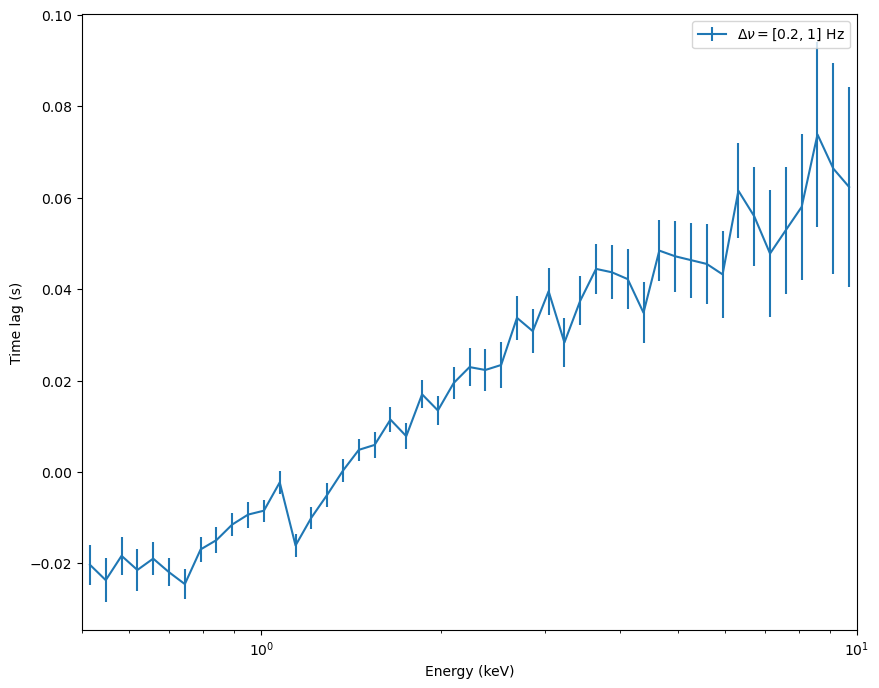

In [116]:
## Plot lag-energy spectrum

fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.errorbar(lagspec_low.energy, lagspec_low.spectrum, yerr=lagspec_low.spectrum_error, label=rf"$\Delta \nu=${lowfreq} Hz")

ax.set_xscale('log')
ax.set_xlim(0.5, 10.)

ax.set_ylabel("Time lag (s)")
ax.set_xlabel("Energy (keV)")
ax.legend()
plt.show()
plt.close("all")

- Covariance and rms spectrum

In [117]:
from stingray import CovarianceSpectrum, RmsSpectrum

We can now compute the covariance spectrum, which represents the energy spectrum of the spectral components that are linearly correlated with the reference band. The covariance spectrum is typically calculated in absolute units ($\mathrm{counts\ s^{-1}}$), and therefore corresponds to the covariance measured in detector space, i.e. convolved with the instrumental response. As a consequence, a larger covariance in these units does not necessarily indicate a higher intrinsic correlated variability of the source, but may simply reflect a higher number of detected photons in a given energy band. In addition, the instrument response includes energy redistribution effects, and the corresponding redistribution matrix is generally non-diagonal. This causes photons originating at a given true energy to be detected over multiple channels, further distorting the observed spectral shape. For these reasons, the detector-space covariance spectrum is influenced by both the effective area and the energy redistribution of the instrument, and must be unfolded through the instrumental response in order to recover the intrinsic energy dependence of the correlated variability.

Alternatively, we can compute the fractional covariance spectrum, obtained by normalizing the covariance by the mean count rate in each energy bin. This removes the dominant dependence on the absolute number of detected photons and provides a measure of the relative amplitude of the correlated variability as a function of energy. While the fractional covariance is still formally defined in detector space, it offers a more direct comparison between different energy bands and reduces the impact of variations in effective area.

In [118]:
norm = "frac"

covspec_low  = CovarianceSpectrum(evt, freq_interval=lowfreq, segment_size=Tseg, bin_time=dt, energy_spec=chan_band, ref_band=ref_band, norm=norm)
covspec_high = CovarianceSpectrum(evt, freq_interval=highfreq, segment_size=Tseg, bin_time=dt, energy_spec=chan_band, ref_band=ref_band, norm=norm)

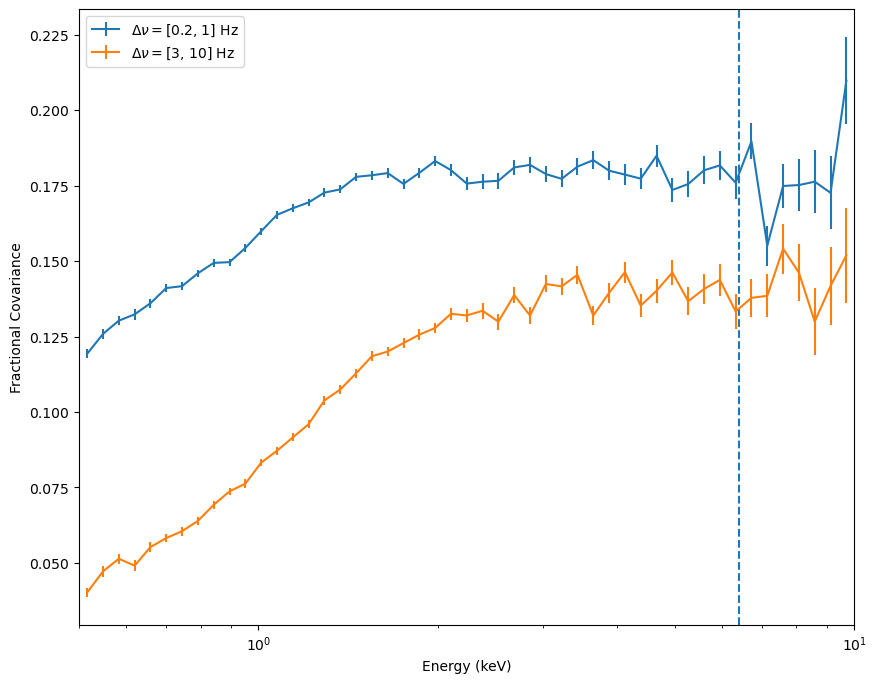

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.errorbar(covspec_low.energy, covspec_low.spectrum, yerr=covspec_low.spectrum_error, label=rf"$\Delta \nu=${lowfreq} Hz")
ax.errorbar(covspec_high.energy, covspec_high.spectrum, yerr=covspec_high.spectrum_error, label=rf"$\Delta \nu=${highfreq} Hz")

ax.set_xscale('log')
ax.set_xlim(0.5, 10.)

#ax.axvline(6.4, linestyle="--")

ax.set_ylabel("Fractional Covariance")
ax.set_xlabel("Energy (keV)")
ax.legend()
plt.show()
plt.close("all")

In [74]:
rmsspec_low  = RmsSpectrum(evt, freq_interval=lowfreq, segment_size=Tseg, bin_time=dt, energy_spec=chan_band, ref_band=ref_band, norm=norm)
rmsspec_high = RmsSpectrum(evt, freq_interval=highfreq, segment_size=Tseg, bin_time=dt, energy_spec=chan_band, ref_band=ref_band, norm=norm)

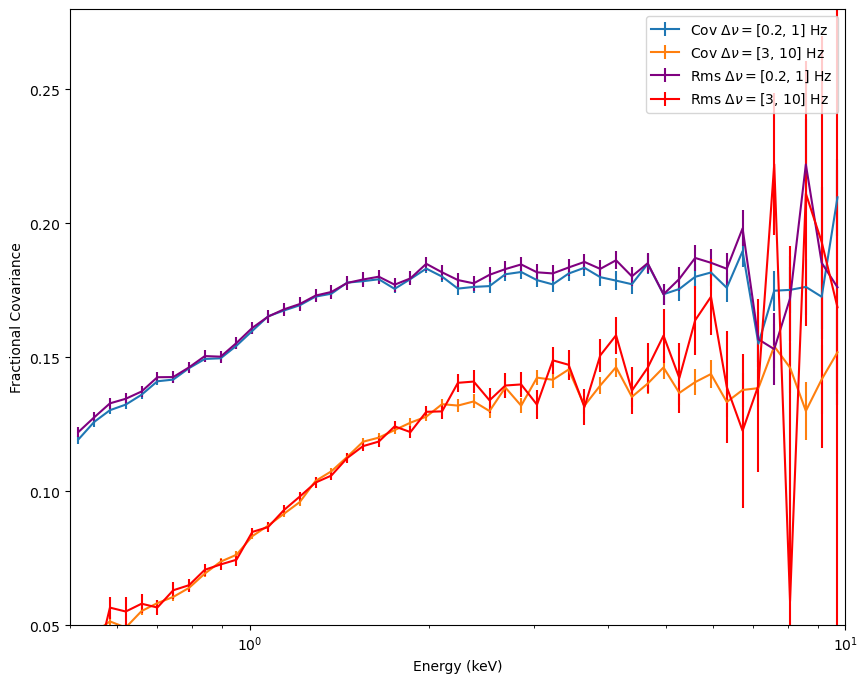

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.errorbar(covspec_low.energy, covspec_low.spectrum, yerr=covspec_low.spectrum_error, label=rf"Cov $\Delta \nu=${lowfreq} Hz")
ax.errorbar(covspec_high.energy, covspec_high.spectrum, yerr=covspec_high.spectrum_error, label=rf"Cov $\Delta \nu=${highfreq} Hz")
ax.errorbar(rmsspec_low.energy, rmsspec_low.spectrum, yerr=rmsspec_low.spectrum_error, label=rf"Rms $\Delta \nu=${lowfreq} Hz", color="purple")
ax.errorbar(rmsspec_high.energy, rmsspec_high.spectrum, yerr=rmsspec_high.spectrum_error, label=rf"Rms $\Delta \nu=${highfreq} Hz", color="red")

ax.set_xscale('log')
ax.set_xlim(0.5, 10.)
ax.set_ylim(0.05, 0.28)

ax.set_ylabel("Fractional Covariance")
ax.set_xlabel("Energy (keV)")
ax.legend()
plt.show()
plt.close("all")

- Linear response in Fourier space

Two signals $x(t)$ and $y(t)$ are linearly correlated if a linear function $h(t)$ exists such that $y(t)=x(t)\ast y(t)=\int_{-\infty}^{+\infty}x(\tau)h(t-\tau)d\tau$. In Fourier space $Y(\nu)=X(\nu)H(\nu)$. The function $h(t)$ is called the "impulse response function", and $H(\nu)$ is the "transfer function". So the cross spectrum is $CS(\nu)=X^{\ast}(\nu)Y(\nu)=|X(\nu)|^2H(\nu)$. In other words the phase of the cross spectrum is given by the phase of the transfer function, and its normalization is given by the power spectrum.  

We can define a python functions that compute the transfer function of a given input impulse response function and the associated lag-frequency spectrum:

In [119]:
## Compute transfer function H(nu) from an impulse response function h(t)

def transfer_function(irf, t):       # t is the array of times over which irf is defined
    dt = t[1] - t[0]                 # time bin of input irf
    H = np.fft.rfft(irf) * dt        # discrete fourier transform (factor dt adjusts normalization)
    nu = np.fft.rfftfreq(len(t), dt) # frequency array
    return nu, H

In [120]:
## Interpolate H onto the desired frequency grid and compute lag

def lag_from_transfer_function(freq, nu_irf, H):
    
    H_interp = np.interp(freq, nu_irf, H.real) + 1j * np.interp(freq, nu_irf, H.imag)
    phase = np.angle(H_interp)
    lag = phase / (2 * np.pi * freq)
    return lag

Now we can give as an input any impulse response function, and use the defined functions above to compute the theoretical lag (to be compared to the data)

Impulse response #1: Top hat $\rightarrow$ uniform response between two delay times (finite, uniform reprocessing region. First-order approximation for an extended reflector)

$h(t)=$$\begin{cases}
\dfrac{1}{\tau_{\max} - \tau_{\min}}, & \tau_{\min} \le t \le \tau_{\max} \\
0, & \text{otherwise}
\end{cases}$

In [158]:
## Example 1: Top-hat 

dt = 1e-4            # time resolution (s)
t_max = 0.2          # must be > tau_max
t = np.arange(0, t_max, dt)

tau_min = 0.01
tau_max = 0.03

irf_tophat = np.zeros_like(t)
mask = (t >= tau_min) & (t <= tau_max)
irf_tophat[mask] = 1.0 / (tau_max - tau_min)

nu_irf, H_tophat = transfer_function(irf_tophat, t)
lag_tophat = lag_from_transfer_function(cs_reb.freq, nu_irf, H_tophat)


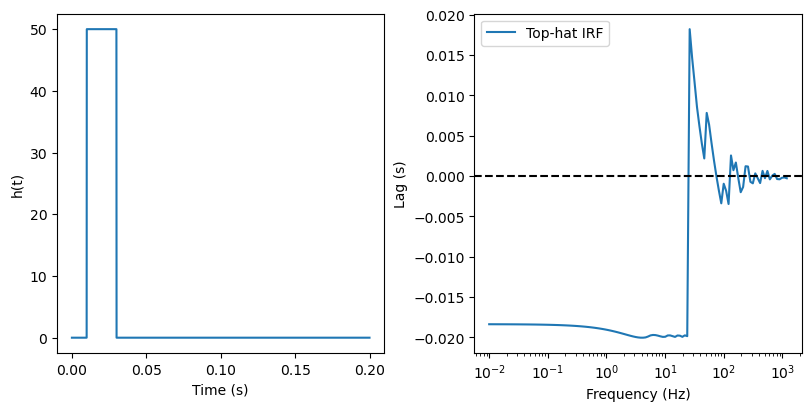

In [159]:
## Plot impulse response and lag-frequency spectrum

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)

ax2.plot(cs_reb.freq, lag_tophat, label='Top-hat IRF')
ax1.plot(t, irf_tophat, label='Top-hat IRF')

ax2.axhline(0, ls='--', color='k')
ax2.set_xscale('log')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Lag (s)')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('h(t)')

ax1.legend
ax2.legend()
plt.show()
plt.close("all")

Example #2: disc-like response $\rightarrow$ non-uniform distribution of delays (first-order approximation for a centrally illuminated, geometrically extended accretion disc)

$h(t)\propto t^{-\alpha},\ \ \ \ \ \  t \in [\tau_{min}, \tau_{max}]$

In [160]:
## Example 2: disc-like response

alpha = 1.5

irf_disc = np.zeros_like(t)
mask = (t >= tau_min) & (t <= tau_max)
irf_disc[mask] = t[mask] ** (-alpha)

# Normalize
irf_disc /= np.trapz(irf_disc, t)

nu_irf, H_disc = transfer_function(irf_disc, t)
lag_disc = lag_from_transfer_function(cs_reb.freq, nu_irf, H_disc)

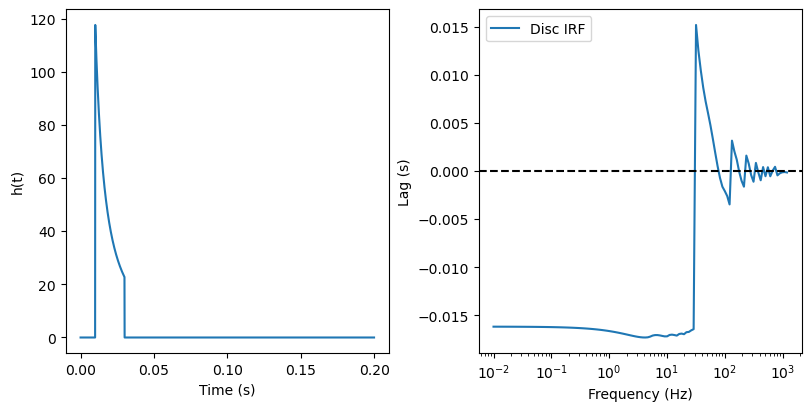

In [161]:
## Plot impulse response and lag-frequency spectrum

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)

ax2.plot(cs_reb.freq, lag_disc, label='Disc IRF')
ax1.plot(t, irf_disc, label='Disc IRF')

ax2.axhline(0, ls='--', color='k')
ax2.set_xscale('log')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Lag (s)')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('h(t)')

ax2.legend()
plt.show()
plt.close("all")